In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[1]") \
                                    .appName('ASL_Recomender') \
                                    .getOrCreate()

In [3]:
spark

In [4]:
df = spark.read.csv("cleaned_data (2).csv", header=True, multiLine=True, quote='"', escape='"', inferSchema=True)

In [19]:
df.show()

+--------------------+--------------------+--------------------+--------+----------------+--------------------+--------------------+-------------+------------+-----------------+-------------+--------------------+--------------+-------------+--------+--------------------+-----+--------------------+------+-----+----------+-------+---------------+--------+------+-----+-------------+----+
|              rating|             title_x|                text|images_x|            asin|         parent_asin|             user_id|    timestamp|helpful_vote|verified_purchase|main_category|             title_y|average_rating|rating_number|features|         description|price|            images_y|videos|store|categories|details|bought_together|subtitle|author|brand|review_length|year|
+--------------------+--------------------+--------------------+--------+----------------+--------------------+--------------------+-------------+------------+-----------------+-------------+--------------------+------------

In [5]:
df = df[['user_id','parent_asin','rating']]
df.show()

+--------------------+-----------+------+
|             user_id|parent_asin|rating|
+--------------------+-----------+------+
|AGKHLEW2SOWHNMFQI...| B00YQ6X8EO|   5.0|
|AGKHLEW2SOWHNMFQI...| B081TJ8YS3|   4.0|
|AE74DYR3QUGVPZJ3P...| B097R46CSY|   5.0|
|AFQLNQNQYFWQZPJQZ...| B09JS339BZ|   1.0|
|AFQLNQNQYFWQZPJQZ...| B08BZ63GMJ|   5.0|
|AGMJ3EMDVL6OWBJF7...| B00R8DXL44|   4.0|
|AHREXOGQPZDA6354M...| B099DRHW5V|   5.0|
|AEYORY2AVPMCPDV57...| B08BBQ29N5|   3.0|
|AFSKPY37N3C43SOI5...| B08P2DZB4X|   5.0|
|AFSKPY37N3C43SOI5...| B086QY6T7N|   5.0|
|AFSKPY37N3C43SOI5...| B08DHTJ25J|   3.0|
|AFSKPY37N3C43SOI5...| B07RBSLNFR|   5.0|
|AFSKPY37N3C43SOI5...| B07SLFWZKN|   3.0|
|AFSKPY37N3C43SOI5...| B08JTNQFZY|   5.0|
|AFSKPY37N3C43SOI5...| B08GLG6W8T|   5.0|
|AFSKPY37N3C43SOI5...| B08M3C6LVS|   3.0|
|AFSKPY37N3C43SOI5...| B07GHPCT6T|   5.0|
|AFSKPY37N3C43SOI5...| B07KG1TWP5|   5.0|
|AFSKPY37N3C43SOI5...| B07W397QG4|   5.0|
|AFSKPY37N3C43SOI5...| B07GDQPG12|   5.0|
+--------------------+-----------+

In [6]:
from pyspark.sql.functions import col, count
df_columns = df.select("user_id","parent_asin","rating") \
                        .withColumnRenamed("parent_asin","product_id")

user_review_counts = df_columns.groupBy("user_id") \
                               .agg(count("*").alias("review_count"))

# Step 3: Filter for users with 5 or more reviews
active_users = user_review_counts.filter(col("review_count") >= 5) \
                                 .select("user_id")

final_df = df_columns.join(active_users,on="user_id",how="inner")

final_df.show()

+--------------------+----------+------+
|             user_id|product_id|rating|
+--------------------+----------+------+
|AE23ZBUF2YVBQPH2N...|B09XF4WD3V|   4.0|
|AE23ZBUF2YVBQPH2N...|B0998BD871|   5.0|
|AE23ZBUF2YVBQPH2N...|B07Y2WSGVW|   3.0|
|AE23ZBUF2YVBQPH2N...|B08S3B8Y5G|   5.0|
|AE23ZBUF2YVBQPH2N...|B08P9MP7L8|   3.0|
|AE23ZBUF2YVBQPH2N...|B08MQWJZSG|   5.0|
|AE23ZBUF2YVBQPH2N...|B08CVTNQP1|   5.0|
|AE23ZBUF2YVBQPH2N...|B08NTD1NM1|   4.0|
|AE23ZBUF2YVBQPH2N...|B08LPC1G23|   4.0|
|AE23ZBUF2YVBQPH2N...|B08GS19PM7|   5.0|
|AE23ZBUF2YVBQPH2N...|B08G5YVHQP|   4.0|
|AE23ZBUF2YVBQPH2N...|B0841WQNNZ|   5.0|
|AE23ZBUF2YVBQPH2N...|B08BF4BKKM|   4.0|
|AE23ZBUF2YVBQPH2N...|B087ZQK2G8|   3.0|
|AE23ZBUF2YVBQPH2N...|B081D2R47W|   3.0|
|AE23ZBUF2YVBQPH2N...|B089R7S73D|   3.0|
|AE2AXZS54WKE3J5ZX...|B09JZNQDSH|   3.0|
|AE2AXZS54WKE3J5ZX...|B01KD8ANOG|   5.0|
|AE2AXZS54WKE3J5ZX...|B08SC7FHWY|   2.0|
|AE2AXZS54WKE3J5ZX...|B00XJGJO1I|   3.0|
+--------------------+----------+------+
only showing top

In [16]:
from pyspark.ml.feature import StringIndexer
# Convert user_id to numeric
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index")
product_indexer = StringIndexer(inputCol="product_id", outputCol="product_index")

# Fit and transform
indexed_df = user_indexer.fit(final_df).transform(final_df)
indexed_df = product_indexer.fit(indexed_df).transform(indexed_df)

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit,ParamGridBuilder


(training,test) = indexed_df.randomSplit([0.8,0.2])

als = ALS(userCol="user_index",itemCol="product_index",ratingCol="rating",coldStartStrategy="drop",nonnegative = True)

param_grid = ParamGridBuilder() \
              .addGrid(als.rank,[12,13,14])\
              .addGrid(als.maxIter,[18,19,20])\
              .addGrid(als.regParam,[.17,.18,.19])\
              .build()

evaluator = RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")

tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator)

model = tvs.fit(training)

best_model = model.bestModel

predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)



In [19]:
print("RMSE = " + str(rmse))

RMSE = 1.3761113741395405


In [20]:
display(predictions.sort("user_index","rating"))

DataFrame[user_id: string, product_id: string, rating: double, user_index: double, product_index: double, prediction: float]

In [21]:
user_recs = best_model.recommendForAllUsers(5)
user_recs.show(truncate=False)

+----------+----------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                               |
+----------+----------------------------------------------------------------------------------------------+
|0         |[{5913, 5.4719176}, {5456, 5.3151083}, {6334, 5.2163095}, {2572, 5.2127647}, {2048, 5.19456}] |
|1         |[{6334, 5.2573695}, {5913, 5.1959023}, {2708, 5.057851}, {516, 5.0058575}, {3232, 5.0013103}] |
|2         |[{4081, 4.9504824}, {5581, 4.8807435}, {3211, 4.8807435}, {6253, 4.8693447}, {6334, 4.8297}]  |
|3         |[{773, 5.5499253}, {6334, 5.5109725}, {5913, 5.5058293}, {4954, 5.444669}, {3135, 5.423415}]  |
|4         |[{6082, 4.795842}, {6042, 4.795842}, {5973, 4.795842}, {5885, 4.795842}, {5884, 4.795842}]    |
|5         |[{5338, 4.7432146}, {4787, 4.7432146}, {3427, 4.7432146}, {752, 4.6469545}, {839, 4.508856}]  |
|6         |[{3135, 5.517585

In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:

from pyspark.sql import functions as F 

import matplotlib.pyplot as plt

# Step 1: Get 3 random users from the test set
sample_users_df = test.select("user_index").distinct().orderBy(F.rand()).limit(3)

# Step 2: Get top 5 recommendations for these users
sample_user_recs = best_model.recommendForUserSubset(sample_users_df, 5)

# Step 3: Explode the recs
exploded_sample = sample_user_recs.selectExpr("user_index", "explode(recommendations) as rec") \
                                  .select("user_index", F.col("rec.product_index"), F.col("rec.rating"))

user_id_mapping = indexed_df.select("user_id", "user_index").distinct()
product_id_mapping = indexed_df.select("product_id", "product_index").distinct()

# Step 4: Map back to original user_id and product_id
sample_pretty_recs = exploded_sample \
    .join(user_id_mapping, on="user_index") \
    .join(product_id_mapping, on="product_index") \
    .select("user_id", "product_id", "rating") \
    .orderBy("user_id", F.col("rating").desc())




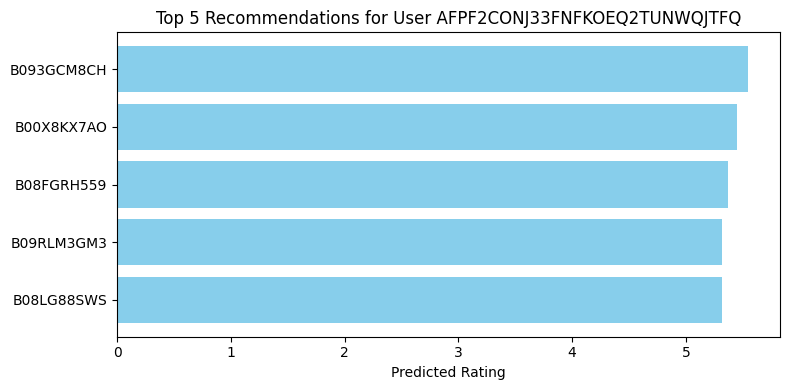

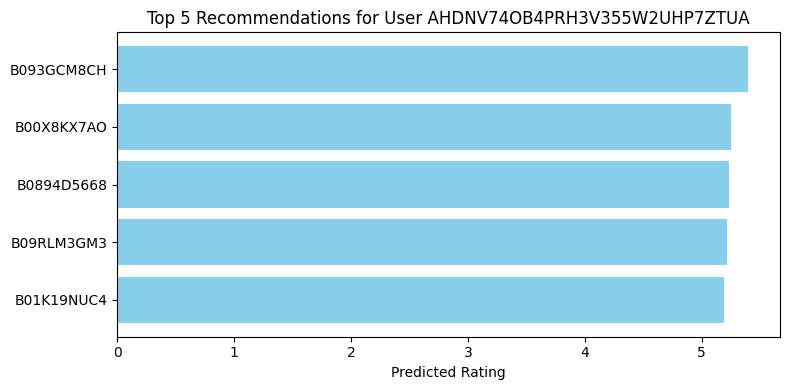

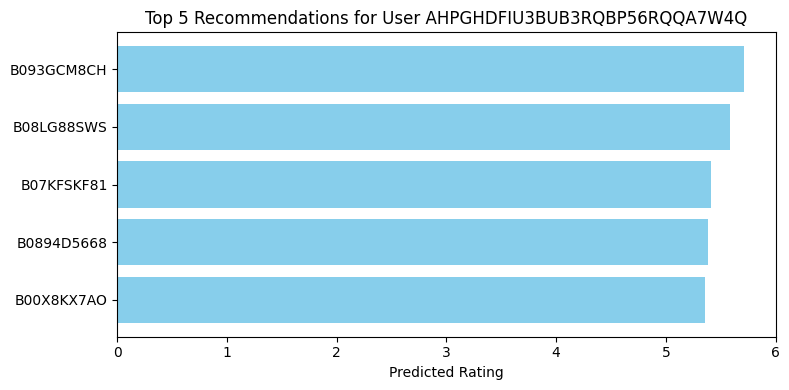

In [28]:
# Convert to Pandas for easier plotting
sample_pdf = sample_pretty_recs.toPandas()

# Plot top 5 recommendations for each user
for user in sample_pdf["user_id"].unique():
    user_data = sample_pdf[sample_pdf["user_id"] == user]
    
    plt.figure(figsize=(8, 4))
    plt.barh(user_data["product_id"], user_data["rating"], color="skyblue")
    plt.xlabel("Predicted Rating")
    plt.title(f"Top 5 Recommendations for User {user}")
    plt.gca().invert_yaxis()  # Invert to have highest ratings on top
    plt.tight_layout()
    plt.show()